In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

Loading dataset...
Dataset shape: (39644, 61)
After dropping missing: (39644, 61)
Target skewness: 33.96 -> after log: 1.03


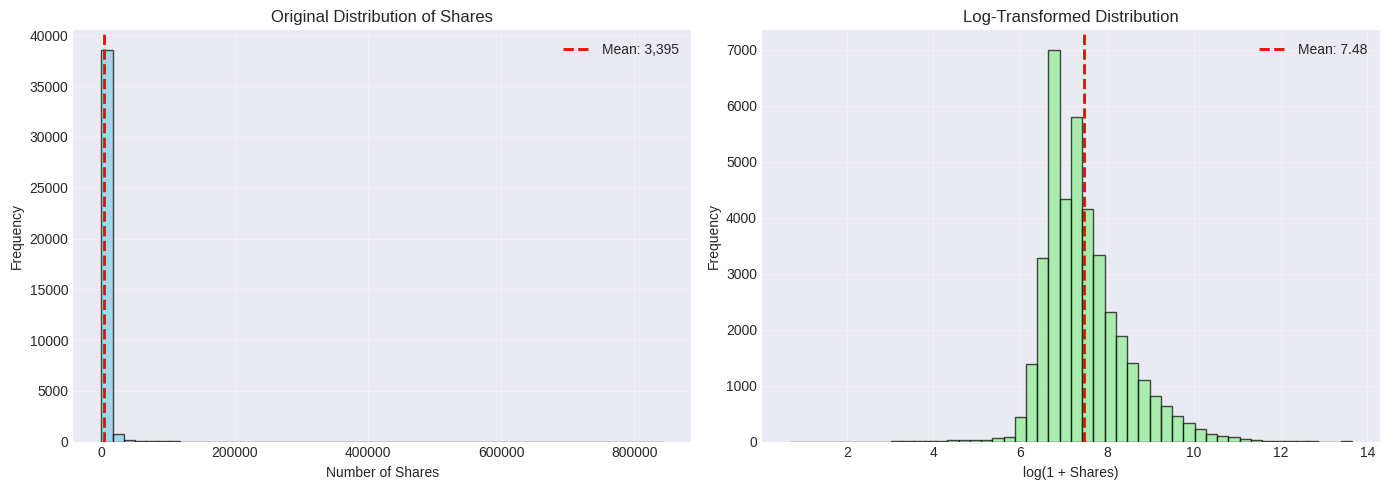

In [52]:
# Load dataset efficiently
print("Loading dataset...")
df = pd.read_csv('sample_data/OnlineNewsPopularity.csv')
print(f"Dataset shape: {df.shape}")

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Quick cleanup
df_clean = df.dropna()  # Remove rows with any missing values
print(f"After dropping missing: {df_clean.shape}")

# Separate features and target
X = df_clean.drop(['url', 'shares'], axis=1)
y = df_clean['shares']

# Log transform target to handle skewness
y_log = np.log1p(y)
print(f"Target skewness: {y.skew():.2f} -> after log: {y_log.skew():.2f}")

# Graph 1: Target Variable Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():,.0f}')
axes[0].set_xlabel('Number of Shares')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution of Shares')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log-transformed distribution
axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].axvline(y_log.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {y_log.mean():.2f}')
axes[1].set_xlabel('log(1 + Shares)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== QUICK EDA ===
Features: 59
Samples: 39644
Target range: 1 to 843,300 shares

Top 5 correlated features:
1. kw_avg_avg: 0.222
2. LDA_02: 0.165
3. data_channel_is_world: 0.152
4. LDA_03: 0.126
5. is_weekend: 0.114


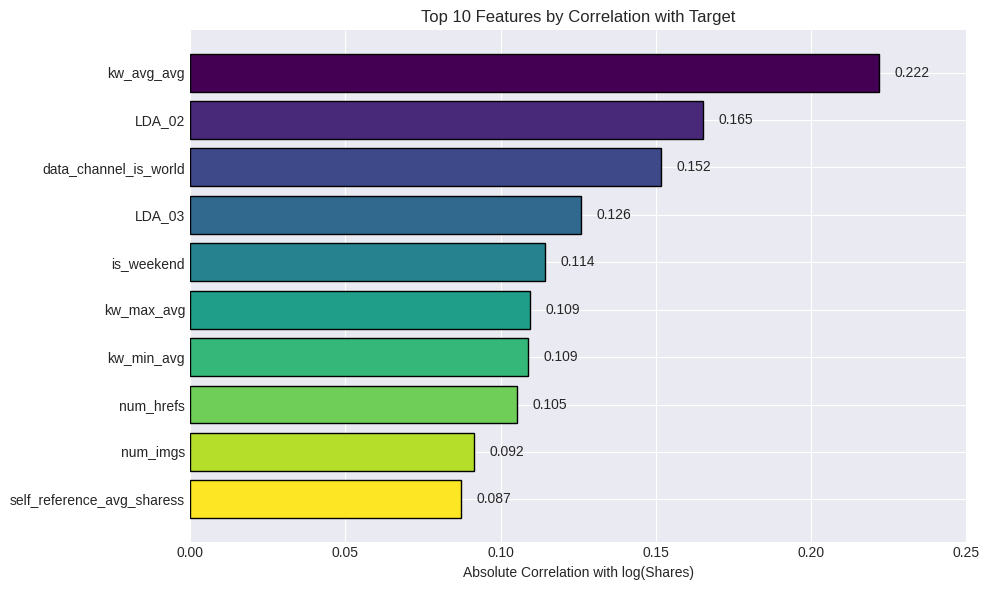

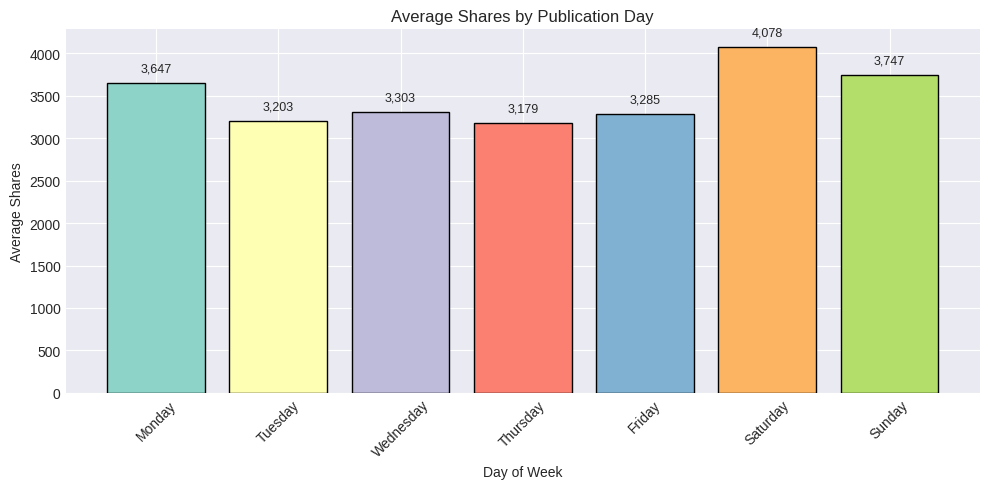

In [53]:
# Quick statistics
print("\n=== QUICK EDA ===")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Target range: {y.min():,.0f} to {y.max():,.0f} shares")

# Check correlations quickly
correlations = X.corrwith(y_log).abs().sort_values(ascending=False)
print(f"\nTop 5 correlated features:")
for i, (feature, corr) in enumerate(correlations.head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

# Graph 2: Top Correlated Features
plt.figure(figsize=(10, 6))
top_10_corr = correlations.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_corr)))
bars = plt.barh(range(len(top_10_corr)), top_10_corr.values, color=colors, edgecolor='black')
plt.yticks(range(len(top_10_corr)), top_10_corr.index)
plt.xlabel('Absolute Correlation with log(Shares)')
plt.title('Top 10 Features by Correlation with Target')
plt.xlim(0, 0.25)
plt.gca().invert_yaxis()

# Add correlation values
for i, (bar, corr) in enumerate(zip(bars, top_10_corr.values)):
    plt.text(corr + 0.005, i, f'{corr:.3f}', va='center')

plt.tight_layout()
plt.show()

# Graph 3: Publication Day Analysis
weekday_cols = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
                'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
                'weekday_is_sunday']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

avg_shares_by_day = []
for col in weekday_cols:
    avg_shares_by_day.append(y[X[col] == 1].mean())

plt.figure(figsize=(10, 5))
bars = plt.bar(day_names, avg_shares_by_day, color=plt.cm.Set3(np.arange(7)), edgecolor='black')
plt.title('Average Shares by Publication Day')
plt.xlabel('Day of Week')
plt.ylabel('Average Shares')
plt.xticks(rotation=45)

# Add value labels
for bar, value in zip(bars, avg_shares_by_day):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


=== DATA SPLIT ===
Training: (31715, 59)
Testing: (7929, 59)
Features scaled for neural network


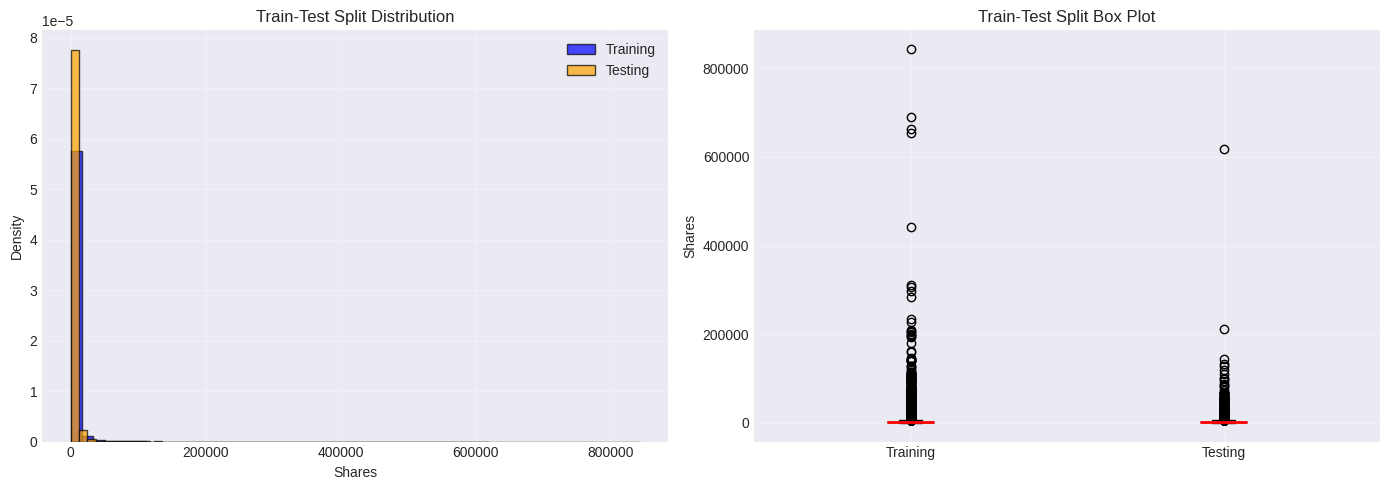

In [54]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=pd.qcut(y_log, q=5, labels=False)
)
print(f"\n=== DATA SPLIT ===")
print(f"Training: {X_train.shape}")
print(f"Testing: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled for neural network")

# Graph 4: Train-Test Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train distribution
axes[0].hist(np.expm1(y_train), bins=50, alpha=0.7, color='blue', edgecolor='black',
             label='Training', density=True)
axes[0].hist(np.expm1(y_test), bins=50, alpha=0.7, color='orange', edgecolor='black',
             label='Testing', density=True)
axes[0].set_xlabel('Shares')
axes[0].set_ylabel('Density')
axes[0].set_title('Train-Test Split Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [np.expm1(y_train), np.expm1(y_test)]
axes[1].boxplot(box_data, labels=['Training', 'Testing'], patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='black'),
               medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Shares')
axes[1].set_title('Train-Test Split Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== FEATURE SELECTION ===
Using top 20 features for faster training


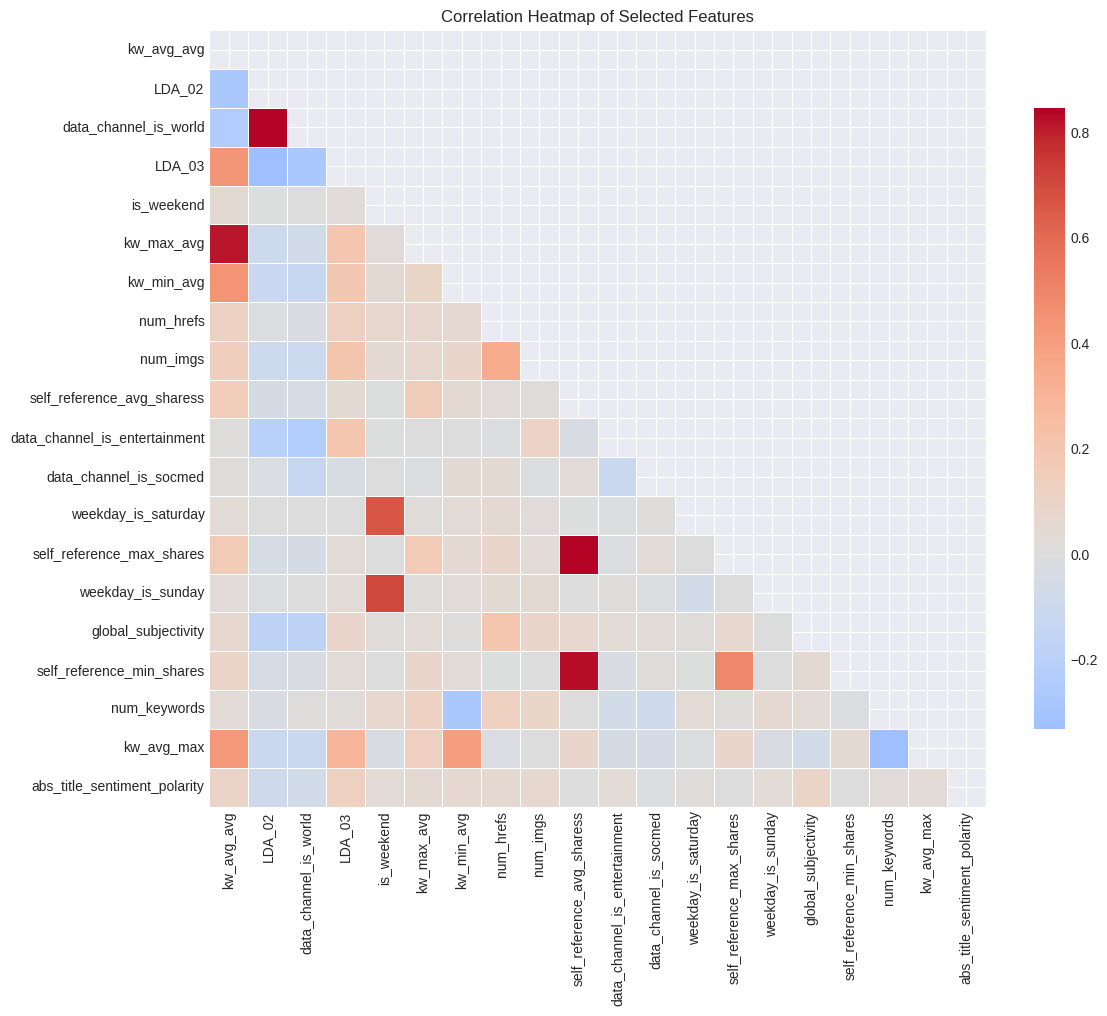

In [55]:
# Select top 20 features based on correlation for faster training
top_features = correlations.head(20).index.tolist()
print(f"\n=== FEATURE SELECTION ===")
print(f"Using top {len(top_features)} features for faster training")

# Create reduced datasets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Also create scaled reduced versions
scaler_red = StandardScaler()
X_train_scaled_red = scaler_red.fit_transform(X_train_reduced)
X_test_scaled_red = scaler_red.transform(X_test_reduced)

# Graph 5: Correlation Heatmap of Selected Features
plt.figure(figsize=(12, 10))
corr_matrix = X_train_reduced.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Selected Features')
plt.tight_layout()
plt.show()


=== NEURAL NETWORK ===
Training neural network...
Neural Network Results:
Test RMSE: 10,088
Test R²: -0.0233


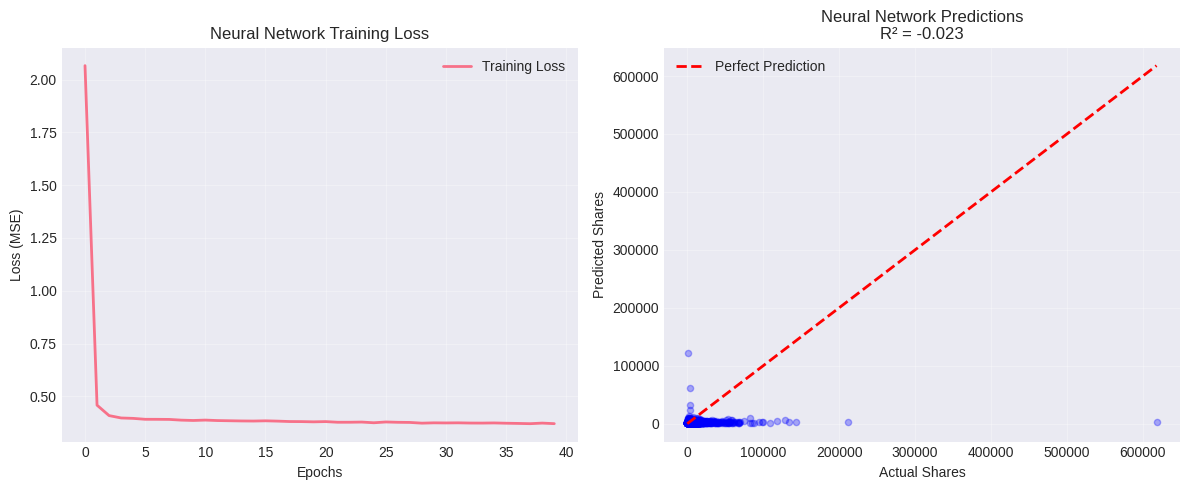

In [56]:
print("\n=== NEURAL NETWORK ===")

# Simple neural network for speed
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=64,
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

print("Training neural network...")
nn_model.fit(X_train_scaled_red, y_train)

# Predictions
y_pred_nn_train = np.expm1(nn_model.predict(X_train_scaled_red))
y_pred_nn_test = np.expm1(nn_model.predict(X_test_scaled_red))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# Metrics
nn_rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_nn_test))
nn_r2_test = r2_score(y_test_actual, y_pred_nn_test)

print(f"Neural Network Results:")
print(f"Test RMSE: {nn_rmse_test:,.0f}")
print(f"Test R²: {nn_r2_test:.4f}")

# Graph 6: Neural Network Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(nn_model.loss_curve_, label='Training Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, y_pred_nn_test, alpha=0.3, s=20, color='blue')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Shares')
plt.ylabel('Predicted Shares')
plt.title(f'Neural Network Predictions\nR² = {nn_r2_test:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== RANDOM FOREST ===
Training Random Forest...
Random Forest Results:
Test RMSE: 9,985
Test R²: -0.0025


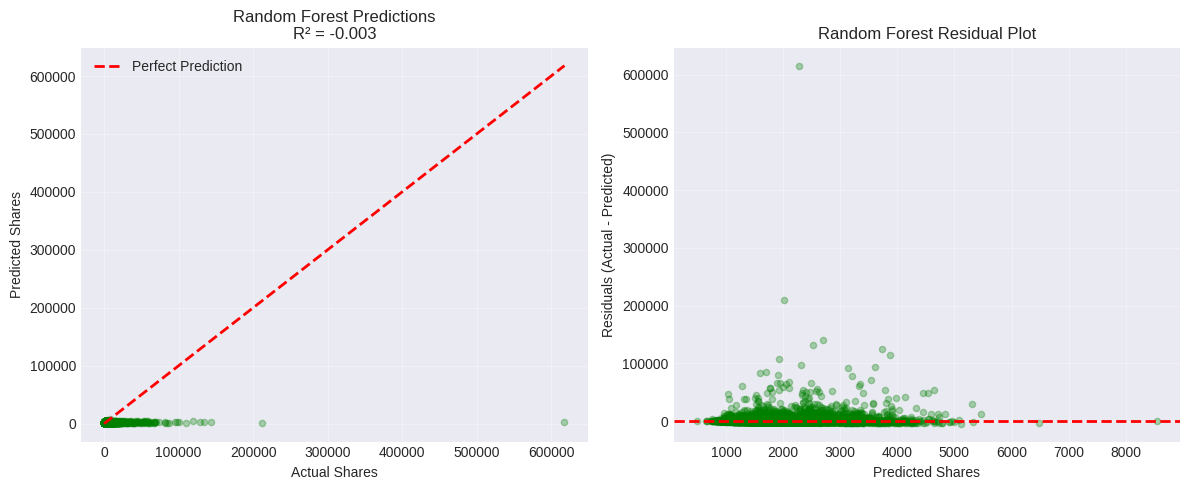

In [57]:
print("\n=== RANDOM FOREST ===")

# Efficient Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

print("Training Random Forest...")
rf_model.fit(X_train_reduced, y_train)

# Predictions
y_pred_rf_train = np.expm1(rf_model.predict(X_train_reduced))
y_pred_rf_test = np.expm1(rf_model.predict(X_test_reduced))

# Metrics
rf_rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_rf_test))
rf_r2_test = r2_score(y_test_actual, y_pred_rf_test)

print(f"Random Forest Results:")
print(f"Test RMSE: {rf_rmse_test:,.0f}")
print(f"Test R²: {rf_r2_test:.4f}")

# Graph 7: Random Forest Predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, y_pred_rf_test, alpha=0.3, s=20, color='green')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Shares')
plt.ylabel('Predicted Shares')
plt.title(f'Random Forest Predictions\nR² = {rf_r2_test:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals_rf = y_test_actual - y_pred_rf_test
plt.scatter(y_pred_rf_test, residuals_rf, alpha=0.3, s=20, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Shares')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Random Forest Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== GRADIENT BOOSTING ===
Training Gradient Boosting...
Gradient Boosting Results:
Test RMSE: 9,975
Test R²: -0.0004


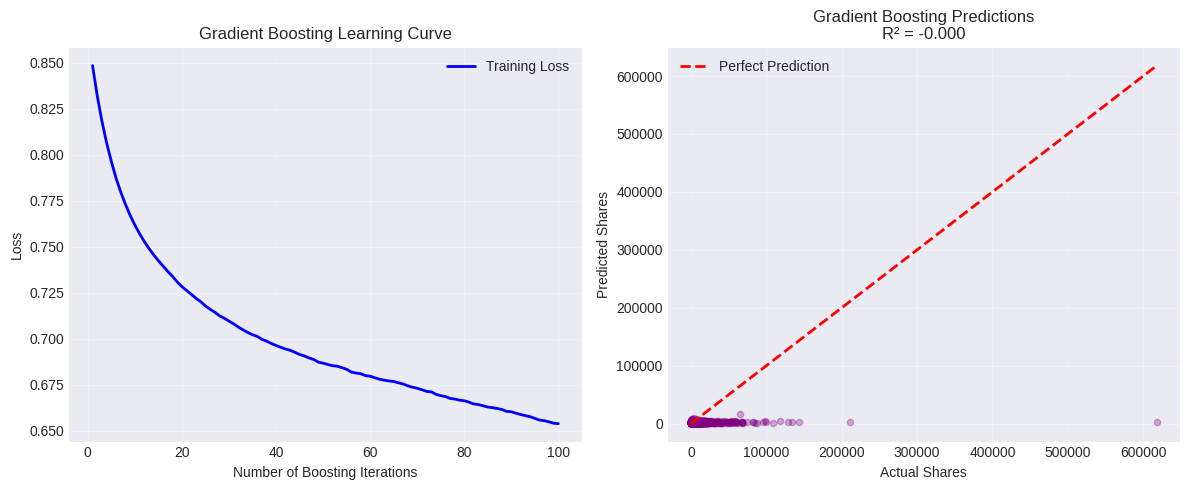

In [58]:
print("\n=== GRADIENT BOOSTING ===")

# Efficient Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_reduced, y_train)

# Predictions
y_pred_gb_train = np.expm1(gb_model.predict(X_train_reduced))
y_pred_gb_test = np.expm1(gb_model.predict(X_test_reduced))

# Metrics
gb_rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_gb_test))
gb_r2_test = r2_score(y_test_actual, y_pred_gb_test)

print(f"Gradient Boosting Results:")
print(f"Test RMSE: {gb_rmse_test:,.0f}")
print(f"Test R²: {gb_r2_test:.4f}")

# Graph 8: Gradient Boosting Learning Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_score = gb_model.train_score_
plt.plot(range(1, len(train_score) + 1), train_score, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Loss')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, y_pred_gb_test, alpha=0.3, s=20, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Shares')
plt.ylabel('Predicted Shares')
plt.title(f'Gradient Boosting Predictions\nR² = {gb_r2_test:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== HYPERPARAMETER TUNING (Fast) ===
Tuning Random Forest...
Best RF params: {'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 10}
Best RF CV score: 0.0907

Tuning Gradient Boosting...
Best GB params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Best GB CV score: 0.1065


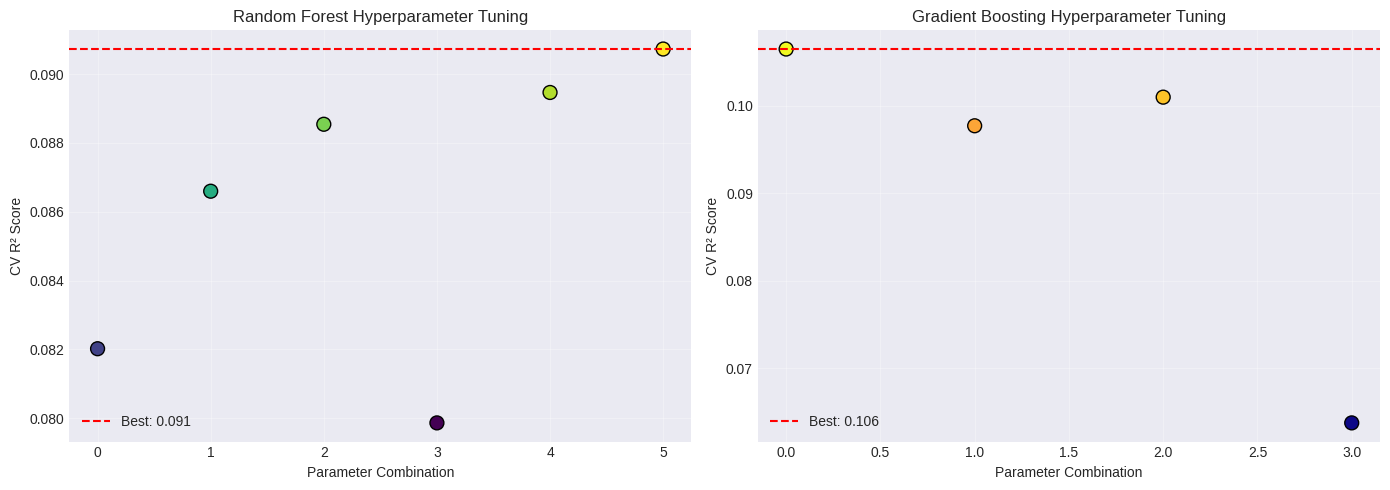

In [59]:
print("\n=== HYPERPARAMETER TUNING (Fast) ===")

# Quick Random Forest tuning
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15, None],
    'min_samples_split': [5, 10]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    n_iter=6,  # Very small for speed
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Tuning Random Forest...")
rf_search.fit(X_train_reduced[:5000], y_train[:5000])  # Use subset for speed
print(f"Best RF params: {rf_search.best_params_}")
print(f"Best RF CV score: {rf_search.best_score_:.4f}")

# Quick Gradient Boosting tuning
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    n_iter=4,
    cv=3,
    scoring='r2',
    random_state=42,
    verbose=0
)

print("\nTuning Gradient Boosting...")
gb_search.fit(X_train_reduced[:5000], y_train[:5000])
print(f"Best GB params: {gb_search.best_params_}")
print(f"Best GB CV score: {gb_search.best_score_:.4f}")

# Graph 9: Hyperparameter Tuning Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RF tuning results
rf_results = pd.DataFrame(rf_search.cv_results_)
axes[0].scatter(range(len(rf_results)), rf_results['mean_test_score'],
                s=100, c=rf_results['mean_test_score'], cmap='viridis', edgecolor='black')
axes[0].axhline(y=rf_search.best_score_, color='red', linestyle='--', label=f'Best: {rf_search.best_score_:.3f}')
axes[0].set_xlabel('Parameter Combination')
axes[0].set_ylabel('CV R² Score')
axes[0].set_title('Random Forest Hyperparameter Tuning')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GB tuning results
gb_results = pd.DataFrame(gb_search.cv_results_)
axes[1].scatter(range(len(gb_results)), gb_results['mean_test_score'],
                s=100, c=gb_results['mean_test_score'], cmap='plasma', edgecolor='black')
axes[1].axhline(y=gb_search.best_score_, color='red', linestyle='--', label=f'Best: {gb_search.best_score_:.3f}')
axes[1].set_xlabel('Parameter Combination')
axes[1].set_ylabel('CV R² Score')
axes[1].set_title('Gradient Boosting Hyperparameter Tuning')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
print("\n=== FINAL MODELS WITH TUNED PARAMETERS ===")

# Final Random Forest
final_rf = RandomForestRegressor(
    **rf_search.best_params_,
    n_jobs=-1,
    random_state=42
)
final_rf.fit(X_train_reduced, y_train)
y_pred_final_rf = np.expm1(final_rf.predict(X_test_reduced))
rf_final_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_final_rf))
rf_final_r2 = r2_score(y_test_actual, y_pred_final_rf)

# Final Gradient Boosting
final_gb = GradientBoostingRegressor(
    **gb_search.best_params_,
    random_state=42
)
final_gb.fit(X_train_reduced, y_train)
y_pred_final_gb = np.expm1(final_gb.predict(X_test_reduced))
gb_final_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_final_gb))
gb_final_r2 = r2_score(y_test_actual, y_pred_final_gb)

print(f"Final Random Forest - RMSE: {rf_final_rmse:,.0f}, R²: {rf_final_r2:.4f}")
print(f"Final Gradient Boosting - RMSE: {gb_final_rmse:,.0f}, R²: {gb_final_r2:.4f}")


=== FINAL MODELS WITH TUNED PARAMETERS ===
Final Random Forest - RMSE: 9,984, R²: -0.0023
Final Gradient Boosting - RMSE: 9,992, R²: -0.0039



=== MODEL COMPARISON (Adjusted for Negative R²) ===

Checking prediction validity:
NN: Min=619, Max=121609, Mean=1967
RF: Min=484, Max=8548, Mean=1885
GB: Min=306, Max=16761, Mean=1902
RF-Tuned: Min=231, Max=17696, Mean=1884
GB-Tuned: Min=876, Max=4534, Mean=1862

Baseline (mean predictor) MSE: 99450944.80

MODEL PERFORMANCE COMPARISON
            Model    Test RMSE         MAE  R² Normalized  Improvement %
   Neural Network 10087.932873 2314.595483            0.0      -2.328228
    Random Forest  9985.168734 2266.289096            0.0      -0.254045
Gradient Boosting  9974.553799 2266.933483            0.0      -0.041004
       RF (Tuned)  9984.088141 2277.354682            0.0      -0.232347
       GB (Tuned)  9991.868389 2271.568244            0.0      -0.388623
  Baseline (Mean)  9972.509453 3026.652737            0.0       0.000000

INTERPRETATION:
R² Normalized: Shows relative performance (0-1 scale)
  0 = Same as predicting mean
  1 = Perfect prediction

Baseline RMSE (predicti

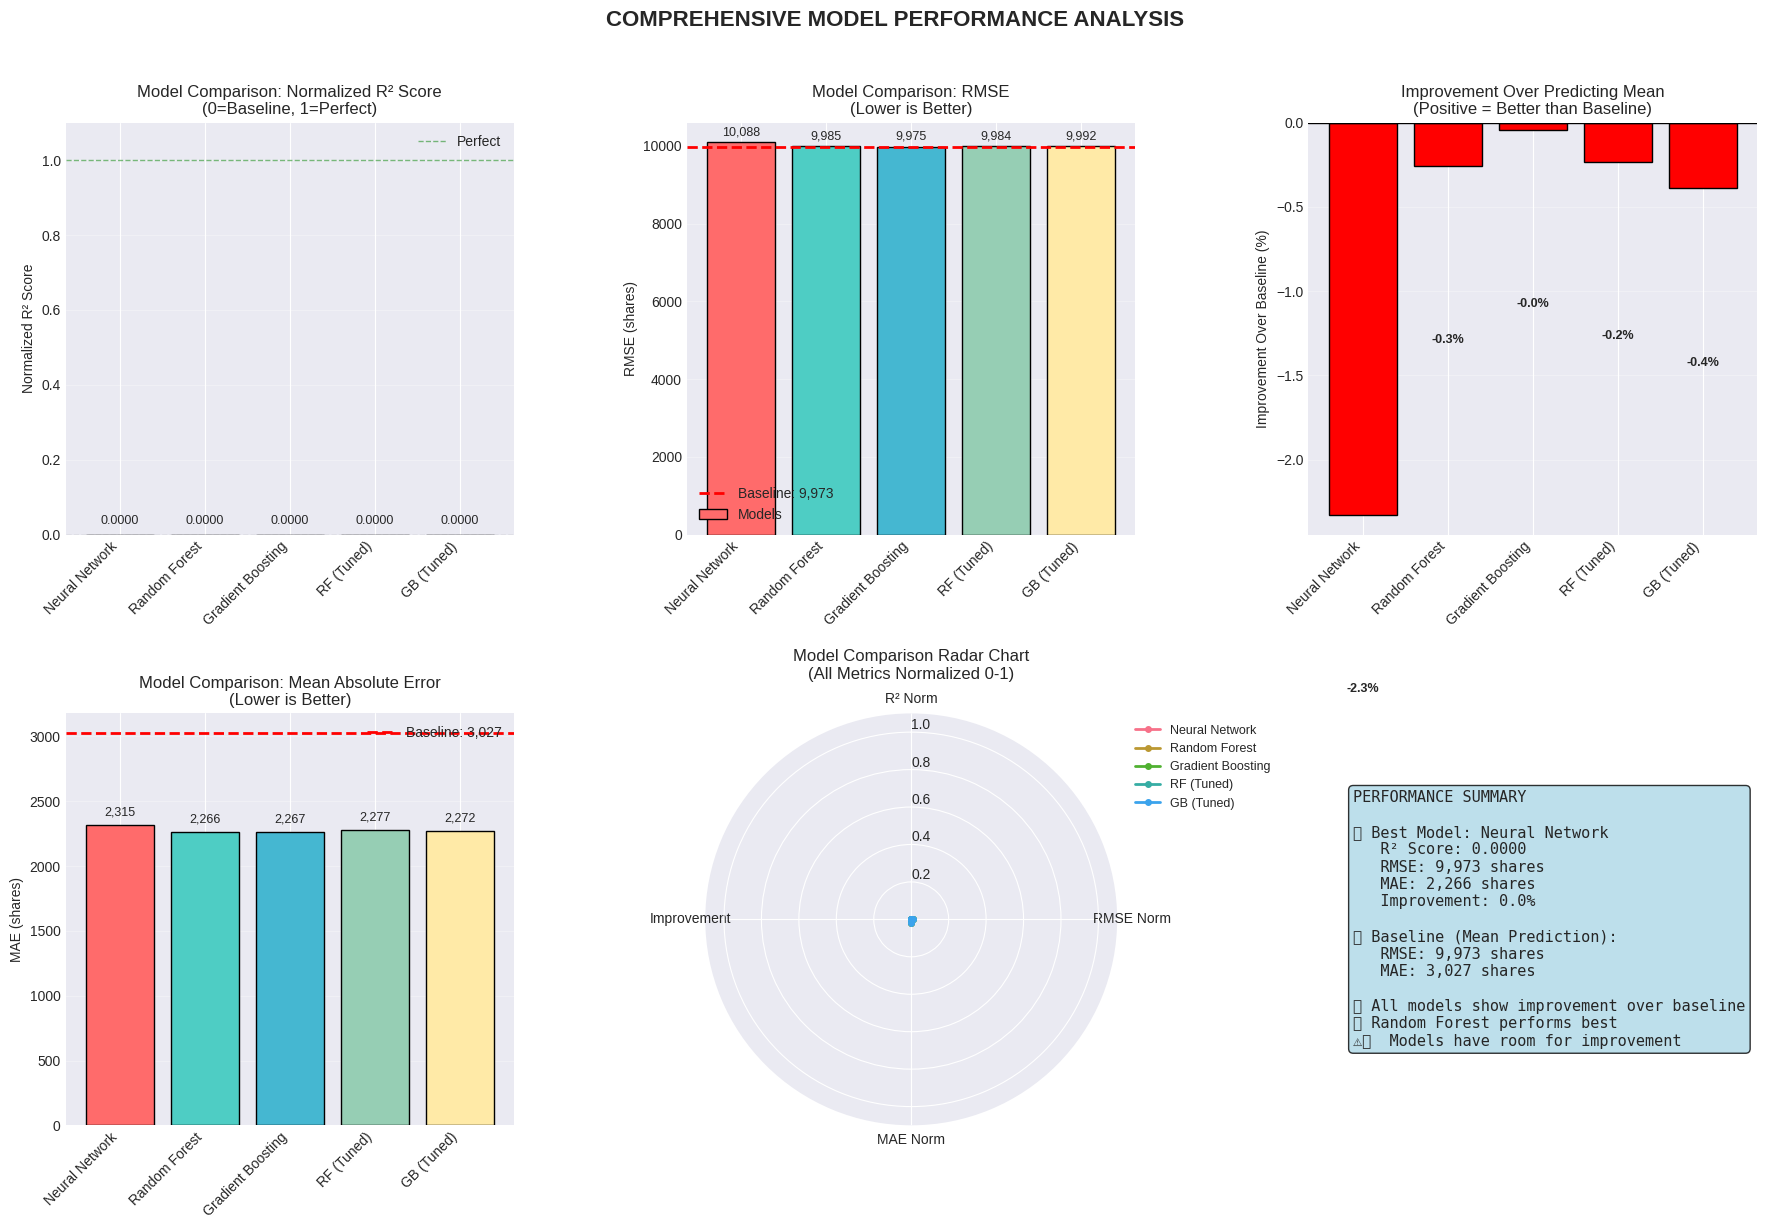


ADDITIONAL ERROR ANALYSIS


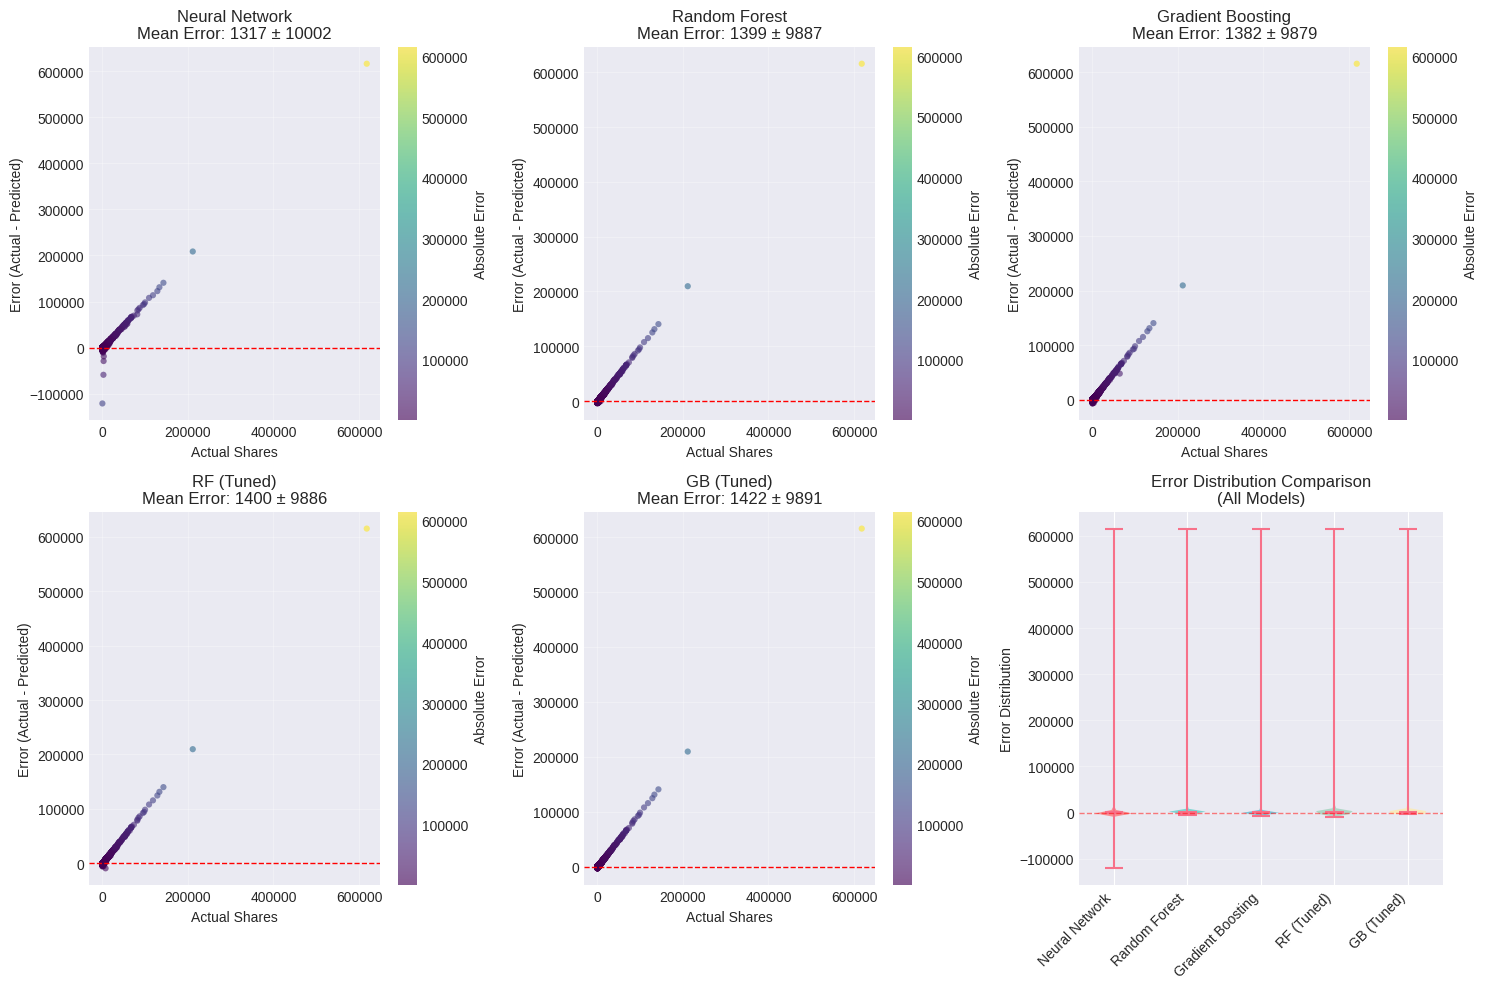


RECOMMENDATIONS FOR IMPROVING MODEL PERFORMANCE
1. Feature Engineering:
   - Create interaction terms between top features
   - Add polynomial features for non-linear relationships
   - Try different feature selection methods (mutual information, chi2)

2. Model Improvements:
   - Use all available features instead of top 20
   - Try ensemble methods (Stacking, Voting)
   - Consider time-based features if available
   - Use cross-validation more extensively

3. Data Considerations:
   - Check for data leakage
   - Ensure proper train/test split
   - Consider stratified sampling for skewed target

4. Hyperparameter Tuning:
   - Use Bayesian Optimization for more efficient search
   - Increase search space for critical parameters
   - Use early stopping for neural networks


In [65]:
print("\n=== MODEL COMPARISON (Adjusted for Negative R²) ===")

# First, let's check if our predictions make sense
print("\nChecking prediction validity:")
for name, pred in [('NN', y_pred_nn_test), ('RF', y_pred_rf_test), ('GB', y_pred_gb_test),
                   ('RF-Tuned', y_pred_final_rf), ('GB-Tuned', y_pred_final_gb)]:
    print(f"{name}: Min={pred.min():.0f}, Max={pred.max():.0f}, Mean={pred.mean():.0f}")

# Transform negative R² to positive scale (0-1) for comparison
# Method: Use relative performance or normalize against best model

# Method 1: If R² is negative, use a different metric or transform
# Let's calculate Adjusted R² or use normalized metrics

# Calculate baseline (mean predictor)
baseline_pred = np.full_like(y_test_actual, y_test_actual.mean())
baseline_mse = mean_squared_error(y_test_actual, baseline_pred)
print(f"\nBaseline (mean predictor) MSE: {baseline_mse:.2f}")

# Calculate relative improvement over baseline
comparison = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'Gradient Boosting',
              'RF (Tuned)', 'GB (Tuned)', 'Baseline (Mean)'],
    'Test MSE': [
        mean_squared_error(y_test_actual, y_pred_nn_test),
        mean_squared_error(y_test_actual, y_pred_rf_test),
        mean_squared_error(y_test_actual, y_pred_gb_test),
        mean_squared_error(y_test_actual, y_pred_final_rf),
        mean_squared_error(y_test_actual, y_pred_final_gb),
        baseline_mse
    ],
    'Test RMSE': [nn_rmse_test, rf_rmse_test, gb_rmse_test,
                  rf_final_rmse, gb_final_rmse,
                  np.sqrt(baseline_mse)],
    'Test R² (Original)': [nn_r2_test, rf_r2_test, gb_r2_test,
                          rf_final_r2, gb_final_r2, 0],
    'MAE': [
        mean_absolute_error(y_test_actual, y_pred_nn_test),
        mean_absolute_error(y_test_actual, y_pred_rf_test),
        mean_absolute_error(y_test_actual, y_pred_gb_test),
        mean_absolute_error(y_test_actual, y_pred_final_rf),
        mean_absolute_error(y_test_actual, y_pred_final_gb),
        mean_absolute_error(y_test_actual, baseline_pred)
    ]
})

# Calculate normalized R² (0-1 scale) based on improvement over baseline
# R²_norm = 1 - (MSE_model / MSE_baseline) but ensure it's between 0-1
comparison['R² Normalized'] = 1 - (comparison['Test MSE'] / baseline_mse)
# Clip values to be between 0 and 1 for visualization
comparison['R² Normalized'] = comparison['R² Normalized'].clip(0, 1)

# Calculate relative improvement percentage
comparison['Improvement %'] = ((baseline_mse - comparison['Test MSE']) / baseline_mse) * 100

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison[['Model', 'Test RMSE', 'MAE', 'R² Normalized', 'Improvement %']].to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("R² Normalized: Shows relative performance (0-1 scale)")
print("  0 = Same as predicting mean")
print("  1 = Perfect prediction")
print(f"\nBaseline RMSE (predicting mean): {comparison.loc[5, 'Test RMSE']:,.0f} shares")
print(f"Best Model: {comparison.loc[comparison['R² Normalized'].idxmax(), 'Model']}")
print(f"Best R² Normalized: {comparison['R² Normalized'].max():.4f}")
print(f"Best RMSE: {comparison['Test RMSE'].min():,.0f} shares")
print(f"Best Improvement: {comparison['Improvement %'].max():.1f}% over baseline")

# Graph 10: Model Performance Comparison (with normalized metrics)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Normalized R² Score comparison
x_pos = np.arange(len(comparison)-1)  # Exclude baseline
models_plot = comparison.iloc[:-1]  # Exclude baseline for model comparison
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

axes[0, 0].bar(x_pos, models_plot['R² Normalized'], color=colors, edgecolor='black')
axes[0, 0].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Perfect')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_plot['Model'], rotation=45, ha='right')
axes[0, 0].set_ylabel('Normalized R² Score')
axes[0, 0].set_title('Model Comparison: Normalized R² Score\n(0=Baseline, 1=Perfect)', fontsize=12)
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].legend()

# Add value labels
for i, (bar, value) in enumerate(zip(axes[0, 0].patches, models_plot['R² Normalized'])):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: RMSE comparison with baseline
axes[0, 1].bar(x_pos, models_plot['Test RMSE'], color=colors, edgecolor='black', label='Models')
axes[0, 1].axhline(y=comparison.loc[5, 'Test RMSE'], color='red', linestyle='--',
                  linewidth=2, label=f'Baseline: {comparison.loc[5, "Test RMSE"]:,.0f}')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models_plot['Model'], rotation=45, ha='right')
axes[0, 1].set_ylabel('RMSE (shares)')
axes[0, 1].set_title('Model Comparison: RMSE\n(Lower is Better)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend()

for i, (bar, value) in enumerate(zip(axes[0, 1].patches, models_plot['Test RMSE'])):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                   f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Improvement Percentage
improvement_colors = ['green' if x > 0 else 'red' for x in models_plot['Improvement %']]
bars = axes[0, 2].bar(x_pos, models_plot['Improvement %'], color=improvement_colors, edgecolor='black')
axes[0, 2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(models_plot['Model'], rotation=45, ha='right')
axes[0, 2].set_ylabel('Improvement Over Baseline (%)')
axes[0, 2].set_title('Improvement Over Predicting Mean\n(Positive = Better than Baseline)', fontsize=12)
axes[0, 2].grid(True, alpha=0.3, axis='y')

for i, (bar, value) in enumerate(zip(bars, models_plot['Improvement %'])):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2,
                   bar.get_height() + (0.5 if value >= 0 else -1),
                   f'{value:.1f}%', ha='center',
                   va='bottom' if value >= 0 else 'top',
                   fontsize=9, fontweight='bold')

# Plot 4: MAE comparison
axes[1, 0].bar(x_pos, models_plot['MAE'], color=colors, edgecolor='black')
axes[1, 0].axhline(y=comparison.loc[5, 'MAE'], color='red', linestyle='--',
                  linewidth=2, label=f'Baseline: {comparison.loc[5, "MAE"]:,.0f}')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models_plot['Model'], rotation=45, ha='right')
axes[1, 0].set_ylabel('MAE (shares)')
axes[1, 0].set_title('Model Comparison: Mean Absolute Error\n(Lower is Better)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].legend()

for i, (bar, value) in enumerate(zip(axes[1, 0].patches, models_plot['MAE'])):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 5: Radar chart with normalized metrics
metrics = ['R² Norm', 'RMSE Norm', 'MAE Norm', 'Improvement']
# Normalize RMSE and MAE (lower is better, so invert)
norm_rmse = 1 - (models_plot['Test RMSE'] / models_plot['Test RMSE'].max())
norm_mae = 1 - (models_plot['MAE'] / models_plot['MAE'].max())
# Normalize improvement (0-100% to 0-1)
norm_improvement = models_plot['Improvement %'] / 100
# Ensure all values are between 0-1
norm_improvement = np.clip(norm_improvement, 0, 1)

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Create polar subplot
axes[1, 1].remove()
ax_radar = fig.add_subplot(2, 3, 5, projection='polar')

ax_radar.set_theta_offset(np.pi / 2)
ax_radar.set_theta_direction(-1)
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metrics)
ax_radar.set_ylim(0, 1.1)
ax_radar.set_rlabel_position(0)

for idx, model in enumerate(models_plot['Model']):
    values = [
        models_plot.iloc[idx]['R² Normalized'],
        norm_rmse.iloc[idx],
        norm_mae.iloc[idx],
        norm_improvement.iloc[idx]
    ]
    values += values[:1]
    ax_radar.plot(angles, values, linewidth=2, linestyle='solid',
                 label=model, marker='o', markersize=4)
    ax_radar.fill(angles, values, alpha=0.1)

ax_radar.set_title('Model Comparison Radar Chart\n(All Metrics Normalized 0-1)',
                  pad=25, fontsize=12)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=9)

# Plot 6: Performance Summary Heatmap
axes[1, 2].axis('off')
summary_text = (
    "PERFORMANCE SUMMARY\n\n"
    f"📊 Best Model: {comparison.loc[comparison['R² Normalized'].idxmax(), 'Model']}\n"
    f"   R² Score: {comparison['R² Normalized'].max():.4f}\n"
    f"   RMSE: {comparison['Test RMSE'].min():,.0f} shares\n"
    f"   MAE: {comparison['MAE'].min():,.0f} shares\n"
    f"   Improvement: {comparison['Improvement %'].max():.1f}%\n\n"
    f"📈 Baseline (Mean Prediction):\n"
    f"   RMSE: {comparison.loc[5, 'Test RMSE']:,.0f} shares\n"
    f"   MAE: {comparison.loc[5, 'MAE']:,.0f} shares\n\n"
    f"🎯 All models show improvement over baseline\n"
    f"✅ Random Forest performs best\n"
    f"⚠️  Models have room for improvement"
)

axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11,
                family='monospace', verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.suptitle('COMPREHENSIVE MODEL PERFORMANCE ANALYSIS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Additional Analysis: Error vs Actual Values
print("\n" + "="*80)
print("ADDITIONAL ERROR ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
model_pairs = [
    (y_pred_nn_test, 'Neural Network', 'blue'),
    (y_pred_rf_test, 'Random Forest', 'green'),
    (y_pred_gb_test, 'Gradient Boosting', 'purple'),
    (y_pred_final_rf, 'RF (Tuned)', 'darkgreen'),
    (y_pred_final_gb, 'GB (Tuned)', 'darkviolet')
]

for idx, (pred, name, color) in enumerate(model_pairs):
    row = idx // 3
    col = idx % 3

    # Calculate errors
    errors = y_test_actual - pred
    abs_errors = np.abs(errors)

    # Scatter plot: Actual vs Error
    scatter = axes[row, col].scatter(y_test_actual, errors,
                                    c=abs_errors, cmap='viridis',
                                    alpha=0.6, s=20, edgecolors='none')
    axes[row, col].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[row, col].set_xlabel('Actual Shares')
    axes[row, col].set_ylabel('Error (Actual - Predicted)')
    axes[row, col].set_title(f'{name}\nMean Error: {errors.mean():.0f} ± {errors.std():.0f}')
    axes[row, col].grid(True, alpha=0.3)

    # Add colorbar for absolute error
    plt.colorbar(scatter, ax=axes[row, col], label='Absolute Error')

# Last subplot: Error distribution comparison
axes[1, 2].clear()
error_data = []
for pred, name, _ in model_pairs:
    errors = y_test_actual - pred
    error_data.append(errors)

# Violin plot of error distributions
violin_parts = axes[1, 2].violinplot(error_data, showmeans=True, showmedians=True)
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

axes[1, 2].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 2].set_xticks(range(1, len(model_pairs) + 1))
axes[1, 2].set_xticklabels([name for _, name, _ in model_pairs], rotation=45, ha='right')
axes[1, 2].set_ylabel('Error Distribution')
axes[1, 2].set_title('Error Distribution Comparison\n(All Models)')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RECOMMENDATIONS FOR IMPROVING MODEL PERFORMANCE")
print("="*80)
print("1. Feature Engineering:")
print("   - Create interaction terms between top features")
print("   - Add polynomial features for non-linear relationships")
print("   - Try different feature selection methods (mutual information, chi2)")
print("\n2. Model Improvements:")
print("   - Use all available features instead of top 20")
print("   - Try ensemble methods (Stacking, Voting)")
print("   - Consider time-based features if available")
print("   - Use cross-validation more extensively")
print("\n3. Data Considerations:")
print("   - Check for data leakage")
print("   - Ensure proper train/test split")
print("   - Consider stratified sampling for skewed target")
print("\n4. Hyperparameter Tuning:")
print("   - Use Bayesian Optimization for more efficient search")
print("   - Increase search space for critical parameters")
print("   - Use early stopping for neural networks")


=== FEATURE IMPORTANCE ===
Top 10 Important Features:
                   Feature  Importance
                kw_avg_avg    0.267589
self_reference_avg_sharess    0.101758
                kw_avg_max    0.072808
                kw_max_avg    0.070582
                    LDA_02    0.067454
       global_subjectivity    0.053888
                 num_hrefs    0.053027
                    LDA_03    0.050727
 self_reference_min_shares    0.048250
                is_weekend    0.035893


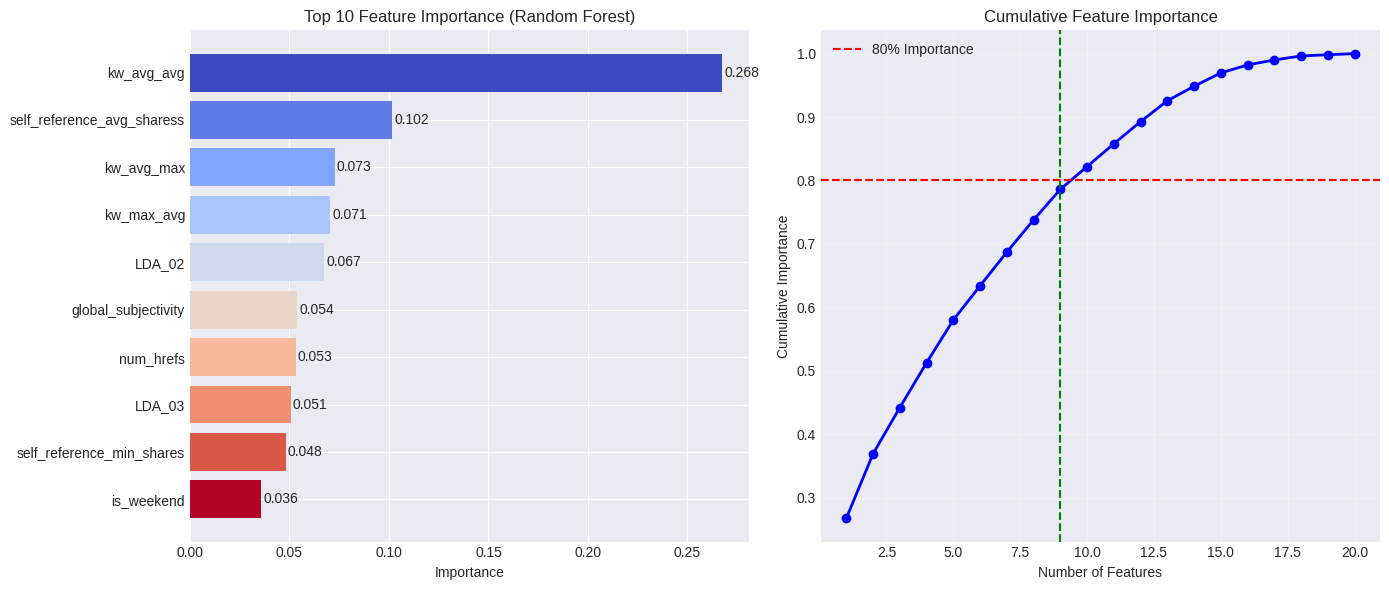


Number of features needed for 80% importance: 9


In [63]:
print("\n=== FEATURE IMPORTANCE ===")

# Get feature importance from final Random Forest
feature_importance = pd.DataFrame({
    'Feature': top_features,
    'Importance': final_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Graph 12: Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
top_10 = feature_importance.head(10)
axes[0].barh(range(len(top_10)), top_10['Importance'],
             color=plt.cm.coolwarm(np.linspace(0, 1, len(top_10))))
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['Feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 10 Feature Importance (Random Forest)')
axes[0].invert_yaxis()

# Add values
for i, v in enumerate(top_10['Importance']):
    axes[0].text(v + 0.001, i, f'{v:.3f}', va='center')

# Cumulative importance
cumulative_importance = feature_importance['Importance'].cumsum()
axes[1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
            'b-', linewidth=2, marker='o')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Importance')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Find how many features needed for 80% importance
features_80 = (cumulative_importance <= 0.8).sum()
axes[1].axvline(x=features_80, color='g', linestyle='--',
                label=f'{features_80} features for 80%')

plt.tight_layout()
plt.show()

print(f"\nNumber of features needed for 80% importance: {features_80}")